## Feature creation.

### Load packages and data files

In [20]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


In [21]:
#import data
df_results = pd.read_csv('../data/nfl_games_pfr.csv')
print(df_results.columns)
print(len(df_results[~df_results['Margin Yds'].isna()]))
print(len(df_results[df_results['Margin Yds'].isna()]))

Index(['Unnamed: 0', 'Week', 'Day', 'Date', 'Time', 'Winner', 'LoserIsHome',
       'Loser', 'PtsW', 'PtsL', 'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week',
       'Winner Abbr', 'Loser Abbr', 'Home Team', 'Away Team', 'Home Score',
       'Away Score', 'Winner Yds', 'Loser Yds', 'Margin Yds', 'Winner TO',
       'Loser TO', 'Margin TO', 'Margin Pts', 'Total Pts', 'Margin Pct',
       'home_team_winner', 'away_win_bonus', 'DateTime',
       'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away'],
      dtype='object')
2649
256


### Create rankings using pagerank from nx

In [22]:
# Graph Functions
def create_graph(game_data, week_num):
    G = nx.DiGraph()
    margin_totals = defaultdict(float)
    game_counts = defaultdict(int)
    
    # Iterate over each game result
    for _, row in game_data.iterrows():
        winner = row['winner']
        loser = row['loser']
        week = row['week']
        margin = row['margin']

        key = (loser, winner)
        margin_totals[key] += margin
        game_counts[key] += 1

    # Add edges with average margin as weight
    for (loser, winner), total_margin in margin_totals.items():
        avg_margin = total_margin / game_counts[(loser, winner)]
        G.add_edge(loser, winner, weight=avg_margin)
    
    return G


In [23]:
# Function to calculate the Strength of Schedule (SoS)
def calculate_strength_of_schedule(graph, pagerank):
    sos = defaultdict(float)
    for team in graph.nodes:
        opponents = list(graph.predecessors(team)) + list(graph.successors(team))
        if opponents:
            sos[team] = sum(pagerank.get(opponent, 0) for opponent in opponents) / len(opponents)
        else:
            sos[team] = 0
    return sos

# Function to generate rankings for each season and week with SoS and iteration
def generate_rankings_with_sos(df_filtered, feature_type, iterations=2):
    # Initialize an empty list to store rankings DataFrames
    ranking_dfs = []

    # Loop over each distinct season in the dataset
    for season in df_filtered['season'].unique():
        # Filter the game data for the current season
        season_data = df_filtered[df_filtered['season'] == season]

        # Loop over the weeks for this season
        for week in range(2, season_data['week'].max() + 1):
            # Filter the game data up to the current week for the current season
            filtered_data = season_data[season_data['week'] <= week]
            
            # Create the directed graph for the current season and weeks
            G = create_graph(filtered_data, week)
            
            # Initial PageRank calculation
            pagerank = dict(nx.pagerank(G, alpha=0.85, weight='weight'))

            # Iteratively refine the rankings with SoS
            for _ in range(iterations):
                sos = calculate_strength_of_schedule(G, pagerank)
                
                # Adjust rankings based on strength of schedule
                adjusted_pagerank = {}
                for team, rank in pagerank.items():
                    adjusted_pagerank[team] = rank * (1 + sos[team])  # Adjust by SoS
                
                # Normalize adjusted PageRank
                total_rank = sum(adjusted_pagerank.values())
                pagerank = {team: rank / total_rank for team, rank in adjusted_pagerank.items()}

            # Convert pagerank dict to DataFrame
            rankings = pd.DataFrame(pagerank.items(), columns=['Team', 'Ranking'])

            # Round the rankings to 5 decimal places
            rankings['Ranking'] = rankings['Ranking'].round(5)
            
            # Add columns indicating the season and week, with a leading zero for weeks
            rankings['SeasonWeek'] = f"{season}_W{str(week).zfill(2)}"
            rankings['Season'] = season
            rankings['Week'] = week
            rankings['Type'] = feature_type
            
            # Append the rankings to the list
            ranking_dfs.append(rankings)
    
    # Concatenate all rankings DataFrames into a single DataFrame
    return pd.concat(ranking_dfs)

In [24]:
### OFFENSE ###
# Filtered data frames for each feature set
df_offense = df_results[~df_results['Margin Yds'].isna()][['season','week','Winner Yds','Loser Yds','Margin Yds']]
df_offense = df_offense.rename(columns={'Winner Yds':'winner', 'Loser Yds':'loser','Margin Yds':'margin'})

# Generate rankings for each feature type
#final_offense_rankings_df = generate_rankings(df_offense, "Offense")
final_offense_rankings_df = generate_rankings_with_sos(df_offense, "Offense")
print(final_offense_rankings_df.head())
print(len(final_offense_rankings_df))

  Team  Ranking SeasonWeek  Season  Week     Type
0  PHI  0.02158   2025_W02    2025     2  Offense
1  DAL  0.03857   2025_W02    2025     2  Offense
2   KC  0.02158   2025_W02    2025     2  Offense
3  LAC  0.03857   2025_W02    2025     2  Offense
4  CAR  0.02158   2025_W02    2025     2  Offense
5376


In [25]:
print(df_offense)

      season  week winner loser  margin
0       2025     1    DAL   PHI     5.0
1       2025     1    LAC    KC    47.0
2       2025     1    JAC   CAR   123.0
3       2025     1    NYJ   PIT   123.0
4       2025     1    CLE   CIN   186.0
...      ...   ...    ...   ...     ...
2900    2015    17    SEA   ARI   122.0
2901    2015    17    DEN   LAC   186.0
2902    2015    17     SF   LAR    94.0
2903    2015    17     KC    LV   134.0
2904    2015    17     GB   MIN   108.0

[2649 rows x 5 columns]


In [26]:
### DEFENSE ###
# Filtered data frames for each feature set
df_defense = df_results[~df_results['Margin Yds'].isna()][['season','week','Winner TO','Loser TO','Margin TO']]
df_defense = df_defense.rename(columns={'Winner TO':'winner', 'Loser TO':'loser','Margin TO':'margin'})

# Generate rankings for each feature type
#final_defense_rankings_df = generate_rankings(df_defense, "Defense")
final_defense_rankings_df = generate_rankings_with_sos(df_defense, "Defense")
print(final_defense_rankings_df.head())
print(len(final_defense_rankings_df))

  Team  Ranking SeasonWeek  Season  Week     Type
0  PHI  0.02604   2025_W02    2025     2  Defense
1  DAL  0.04625   2025_W02    2025     2  Defense
2   KC  0.02499   2025_W02    2025     2  Defense
3  LAC  0.02499   2025_W02    2025     2  Defense
4  JAC  0.02604   2025_W02    2025     2  Defense
5376


In [27]:
### SCORE ###
# Filtered data frames for each feature set
df_score = df_results[~df_results['Margin Yds'].isna()][['season','week','Winner Abbr','Loser Abbr','Margin Pts']]
df_score = df_score.rename(columns={'Winner Abbr':'winner', 'Loser Abbr':'loser', 'Margin Pts':'margin'})

# Generate rankings for each feature type
#final_score_rankings_df = generate_rankings(df_score, "Score")
final_score_rankings_df = generate_rankings_with_sos(df_score, "Score")
print(final_score_rankings_df.head())
print(len(final_score_rankings_df))

  Team  Ranking SeasonWeek  Season  Week   Type
0  DAL  0.02158   2025_W02    2025     2  Score
1  PHI  0.03857   2025_W02    2025     2  Score
2   KC  0.02158   2025_W02    2025     2  Score
3  LAC  0.03857   2025_W02    2025     2  Score
4  CAR  0.02158   2025_W02    2025     2  Score
5376


In [28]:
# Concatenate all feature rankings into a single DataFrame
final_rankings_df = pd.concat([final_offense_rankings_df, final_score_rankings_df, final_defense_rankings_df])
print(final_rankings_df.head())
print(len(final_rankings_df))
final_rankings_df.to_csv('../data/nfl_rankings_combined.csv')

  Team  Ranking SeasonWeek  Season  Week     Type
0  PHI  0.02158   2025_W02    2025     2  Offense
1  DAL  0.03857   2025_W02    2025     2  Offense
2   KC  0.02158   2025_W02    2025     2  Offense
3  LAC  0.03857   2025_W02    2025     2  Offense
4  CAR  0.02158   2025_W02    2025     2  Offense
16128


In [29]:
# Function to filter data for Home/Away advantage that uses matched games over the prior 3 seasons
def filter_data_for_game(game_row, full_data):
    current_season = game_row['season']
    current_week = game_row['week']
    
    # Get relevant seasons: current season and previous 3
    relevant_seasons = [current_season - i for i in range(4)]
    
    # Filter data to only include these seasons
    filtered_data = full_data[(full_data['season'].isin(relevant_seasons)) & 
                              ((full_data['season'] < current_season) | 
                               ((full_data['season'] == current_season) & 
                                (full_data['week'] < current_week)))]
    
    return filtered_data

In [30]:
df_fieldadv = df_results[~df_results['Margin Yds'].isna()][['season','week','Home Team','Away Team','Home Score', 'Away Score']]
# Filter to only include games up to week 16 for field advantage calculation
df_fieldadv = df_fieldadv[df_fieldadv['week'] <= 16]
df_fieldadv['Margin HomeAway'] = df_fieldadv['Home Score'] - df_fieldadv['Away Score']

# List to store the aggregated team-level impacts across all weeks
all_team_impacts = []

# Dictionary to store performance data for home and away impacts
home_away_impacts = []

# Iterate over each season and week in the dataset
for season in df_fieldadv['season'].unique():
    for week in df_fieldadv[df_fieldadv['season'] == season]['week'].unique():
        # Filter games up to the current season and week, including the current season and the three prior seasons
        relevant_games = df_fieldadv[(df_fieldadv['season'] >= (season - 3)) & ((df_fieldadv['season'] < season) | ((df_fieldadv['season'] == season) & (df_fieldadv['week'] <= week)))]
        
        # Get a list of unique teams for the relevant period
        teams = relevant_games['Home Team'].unique()
        
        for team in teams:
            # Filter games where the team is either home or away
            home_games = relevant_games[relevant_games['Home Team'] == team]
            away_games = relevant_games[relevant_games['Away Team'] == team]

            # Iterate over each opponent the team has faced
            for opponent in home_games['Away Team'].unique():
                # Check if the team played both a home and away game against this opponent
                if opponent in away_games['Home Team'].values:
                    # Home game(s) against this opponent
                    home_matchups = home_games[home_games['Away Team'] == opponent]
                    # Away game(s) against this opponent
                    away_matchups = away_games[away_games['Home Team'] == opponent]

                    # Ensure there is at least one home and one away game
                    if not home_matchups.empty and not away_matchups.empty:
                        # Compute the average points differential at home and away
                        home_avg_diff = home_matchups['Margin HomeAway'].mean()
                        away_avg_diff = away_matchups['Margin HomeAway'].mean()

                        # Count the number of matchups used in the calculations
                        num_matchups = len(home_matchups) + len(away_matchups)

                        # Store the impact data for home and away
                        home_away_impacts.append({
                            'Team': team,
                            'Opponent': opponent,
                            'Home_Avg_Diff': home_avg_diff,
                            'Away_Avg_Diff': away_avg_diff,
                            'Home_Impact': home_avg_diff - away_avg_diff,
                            'Away_Impact': away_avg_diff - home_avg_diff,
                            'Matchup_Count': num_matchups,
                            'SeasonWeek': f"{season}_W{str(week).zfill(2)}"
                        })

        # Convert the results to a DataFrame for the current season and week
        home_away_impact_df = pd.DataFrame(home_away_impacts)
        
        # Filter matchups with more than 3 games for the current season and week
        filtered_impact_df = home_away_impact_df[(home_away_impact_df['SeasonWeek'] == f"{season}_W{str(week).zfill(2)}") & (home_away_impact_df['Matchup_Count'] > 3)]
        
        # Group by team and calculate the mean home vs away impact
        team_home_away_impact = filtered_impact_df.groupby('Team').agg({
            'Home_Avg_Diff': 'mean',
            'Away_Avg_Diff': 'mean',
            'Home_Impact': 'mean',
            'Away_Impact': 'mean',
            'Matchup_Count': 'sum'
        }).reset_index()
        
        # Add a column to indicate the current season and week
        team_home_away_impact['SeasonWeek'] = f"{season}_W{str(week).zfill(2)}"
        team_home_away_impact['Season'] = season
        team_home_away_impact['Week'] = week

        # Round the aggregated values to 3 decimals
        team_home_away_impact = team_home_away_impact.round({'Home_Avg_Diff': 3, 'Away_Avg_Diff': 3, 'Home_Impact': 3, 'Away_Impact': 3})
        
        # Append the current week's team-level impacts to the overall list
        all_team_impacts.append(team_home_away_impact)

# Combine all weekly impacts into a single DataFrame
final_team_impact_df = pd.concat(all_team_impacts, ignore_index=True)

# Print or store the final aggregated team-level impacts
print(final_team_impact_df)

     Team  Home_Avg_Diff  Away_Avg_Diff  Home_Impact  Away_Impact  \
0     ARI        -11.000          7.500      -18.500       18.500   
1     ATL          3.833          0.111        3.722       -3.722   
2     BAL          7.722         -1.333        9.056       -9.056   
3     BUF         14.167         -3.750       17.917      -17.917   
4     CAR          0.000         19.000      -19.000       19.000   
...   ...            ...            ...          ...          ...   
4282  SEA          7.500          4.500        3.000       -3.000   
4283   SF         -9.000         21.500      -30.500       30.500   
4284   TB         -3.250         -2.500       -0.750        0.750   
4285  TEN          8.500         13.500       -5.000        5.000   
4286  WAS          5.000         -9.500       14.500      -14.500   

      Matchup_Count SeasonWeek  Season  Week  
0                14   2025_W01    2025     1  
1                16   2025_W01    2025     1  
2                14   2025_W01

In [31]:
print(final_team_impact_df.columns)

Index(['Team', 'Home_Avg_Diff', 'Away_Avg_Diff', 'Home_Impact', 'Away_Impact',
       'Matchup_Count', 'SeasonWeek', 'Season', 'Week'],
      dtype='object')


#### Create additional features and interaction variables

In [32]:
# Preprocess the combined_rankings dataframe to create offensive and defensive rank features
rankings = final_rankings_df.pivot(index=['Team', 'SeasonWeek', 'Season', 'Week'], columns='Type', values='Ranking').reset_index()
rankings.rename(columns={'Offense': 'OffenseRank', 'Defense': 'DefenseRank', 'Score': 'ScoreRank'}, inplace=True)

# Adjust rankings to use the prior week's data
rankings['Week'] += 1

# Merge the rankings with game results to create the feature set
def merge_rankings(df, team_column, prefix):
    return df.merge(rankings, left_on=[team_column, 'season', 'week'], right_on=['Team', 'Season', 'Week'], how='left') \
             .rename(columns={'OffenseRank': f'{prefix}_OffenseRank',
                              'DefenseRank': f'{prefix}_DefenseRank',
                              'ScoreRank': f'{prefix}_ScoreRank'})

merged_df = merge_rankings(df_results, 'Home Team', 'Home')
merged_df = merge_rankings(merged_df, 'Away Team', 'Away')
print(len(merged_df[merged_df['Margin Yds'].isna()]),' 1')

# Drop unnecessary columns
merged_df.drop(columns=['Unnamed: 0', 'Team_x', 'Season_x', 'SeasonWeek_x', 'Week_x',
                        'Team_y', 'Season_y', 'SeasonWeek_y', 'Week_y'], inplace=True)

print(len(merged_df[merged_df['Margin Yds'].isna()]),' 2')

# Filter to only games where rankings exist for both teams
merged_df.dropna(subset=['Home_OffenseRank', 'Home_DefenseRank', 'Away_OffenseRank', 'Away_DefenseRank'], inplace=True)
print(len(merged_df[merged_df['Margin Yds'].isna()]),' 3')

# Create target variable (spread)
merged_df['Spread'] = merged_df.apply(lambda row: row['PtsW'] - row['PtsL']
                                      if row['Home Team'] == row['Winner Abbr']
                                      else row['PtsL'] - row['PtsW'], axis=1)
print(len(merged_df[merged_df['Margin Yds'].isna()]),' 4')

# Create feature deltas and ratios
rank_features = ['OffenseRank', 'DefenseRank', 'ScoreRank']
for feature in rank_features:
    merged_df[f'Delta_{feature}'] = merged_df[f'Home_{feature}'] - merged_df[f'Away_{feature}']
    merged_df[f'Ratio_{feature}'] = merged_df[f'Home_{feature}'] / (merged_df[f'Away_{feature}'] + 1e-5)

# Create interaction and quadratic terms
interaction_terms = [
    ('Home_OffenseRank', 'Away_DefenseRank'),
    ('Away_OffenseRank', 'Home_DefenseRank'),
    ('Home_OffenseRank', 'Away_OffenseRank'),
    ('Away_DefenseRank', 'Home_DefenseRank')
]
for i, (col1, col2) in enumerate(interaction_terms, 1):
    merged_df[f'intTerm{i}'] = merged_df[col1] * merged_df[col2]

quadratic_terms = [
    'Home_OffenseRank', 'Away_OffenseRank', 'Home_DefenseRank', 'Away_DefenseRank'
]
for i, col in enumerate(quadratic_terms, 1):
    merged_df[f'quadTerm{i}'] = merged_df[col] ** 2

# Create strength features
merged_df['HomeStrength'] = merged_df['Home_OffenseRank'] + merged_df['Home_DefenseRank'] + merged_df['Home_ScoreRank']
merged_df['AwayStrength'] = merged_df['Away_OffenseRank'] + merged_df['Away_DefenseRank'] + merged_df['Away_ScoreRank']

print(merged_df.columns)
print(len(merged_df))


256  1
256  2
17  3
17  4
Index(['Day', 'Date', 'Time', 'Winner', 'LoserIsHome', 'Loser', 'PtsW', 'PtsL',
       'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week', 'Winner Abbr',
       'Loser Abbr', 'Home Team', 'Away Team', 'Home Score', 'Away Score',
       'Winner Yds', 'Loser Yds', 'Margin Yds', 'Winner TO', 'Loser TO',
       'Margin TO', 'Margin Pts', 'Total Pts', 'Margin Pct',
       'home_team_winner', 'away_win_bonus', 'DateTime',
       'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'Home_DefenseRank',
       'Home_OffenseRank', 'Home_ScoreRank', 'Week', 'Away_DefenseRank',
       'Away_OffenseRank', 'Away_ScoreRank', 'Spread', 'Delta_OffenseRank',
       'Ratio_OffenseRank', 'Delta_DefenseRank', 'Ratio_DefenseRank',
       'Delta_ScoreRank', 'Ratio_ScoreRank', 'intTerm1', 'intTerm2',
       'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3',
       'quadTerm4', 'HomeStrength', 'AwayStrength'],
      dtype='object')
2331


In [33]:
# Adjust home away advantage to use the prior week's data
final_team_impact_df['Week'] += 1

# Merge with home/away impact to create the feature set
adv_df = pd.merge(
    merged_df,
    final_team_impact_df,
    left_on=['Home Team', 'season', 'week'],
    right_on=['Team', 'Season', 'Week'],
    suffixes=('', '_Home'), how='left'
)


adv_df = pd.merge(
    adv_df,
    final_team_impact_df,
    left_on=['Away Team', 'season', 'week'],
    right_on=['Team', 'Season', 'Week'],
    suffixes=('', '_Away'), how='left'
)



# Drop unnecessary columns
adv_df.drop(columns=['Team', 'Home_Avg_Diff',
            'Away_Avg_Diff', 'Away_Impact', 'Matchup_Count',
            'SeasonWeek', 'Season', 'Week_Home', 'Team_Away', 'Home_Avg_Diff_Away',
            'Away_Avg_Diff_Away', 'Home_Impact_Away', 
            'Matchup_Count_Away', 'SeasonWeek_Away', 'Season_Away', 'Week_Away'], inplace=True)

adv_df.rename(columns={'Away_Impact_Away': 'Away_Impact'}, inplace=True)
adv_df['Home_Impact'] = adv_df['Home_Impact'].fillna(0)
adv_df['Away_Impact'] = adv_df['Away_Impact'].fillna(0)

adv_df['Impact'] = adv_df['Home_Impact'] + adv_df['Away_Impact']
adv_df['ImpactNeg'] = adv_df['Home_Impact'] - adv_df['Away_Impact']

print(adv_df.head())
print(len(merged_df), len(adv_df))

   Day        Date    Time              Winner LoserIsHome              Loser  \
0  Thu  2025-09-18  8:15PM      Miami Dolphins           @      Buffalo Bills   
1  Sun  2025-09-21  1:00PM     Atlanta Falcons           @  Carolina Panthers   
2  Sun  2025-09-21  1:00PM  Cincinnati Bengals           @  Minnesota Vikings   
3  Sun  2025-09-21  1:00PM  Indianapolis Colts           @   Tennessee Titans   
4  Sun  2025-09-21  1:00PM   Green Bay Packers           @   Cleveland Browns   

   PtsW  PtsL  YdsW  TOW  ...  quadTerm1  quadTerm2  quadTerm3  quadTerm4  \
0   NaN   NaN   NaN  NaN  ...   0.001488   0.000466   0.000678   0.002139   
1   NaN   NaN   NaN  NaN  ...   0.000466   0.001488   0.002139   0.000625   
2   NaN   NaN   NaN  NaN  ...   0.000466   0.000466   0.000625   0.000678   
3   NaN   NaN   NaN  NaN  ...   0.000466   0.001488   0.000678   0.000678   
4   NaN   NaN   NaN  NaN  ...   0.001488   0.005281   0.002139   0.000651   

  HomeStrength AwayStrength Home_Impact Away_Impac

### Create other team strength features based only on final scores

In [34]:
# Step 1: Select and sort the data
df_pts = df_results[~df_results['Margin Yds'].isna()][['season','week','Home Team','Away Team','Home Score', 'Away Score']].sort_values(by=['season', 'week'])
# Filter to only include games up to week 16 for points strength calculation
df_pts = df_pts[df_pts['week'] <= 16]
print(len(df_pts))

# Step 2: Get all unique teams
teams = pd.unique(df_pts[['Home Team', 'Away Team']].values.ravel('K'))

# Step 3: Create empty lists to store results
results = []

# Step 4: Loop through each team and season to calculate cumulative metrics
for team in teams:
    for season, group in df_pts.groupby('season'):
        group = group.reset_index(drop=True)
        cumulative_points_scored = 0
        cumulative_points_allowed = 0
        cumulative_games = 0
        points_scored_list = []
        points_allowed_list = []

        max_week = group['week'].max()
        
        for week in range(2, max_week + 1):
            week_data = group[group['week'] == week]
            row = week_data[(week_data['Home Team'] == team) | (week_data['Away Team'] == team)]
            
            if not row.empty:
                row = row.iloc[0]
                if row['Home Team'] == team:
                    points_scored = row['Home Score']
                    points_allowed = row['Away Score']
                elif row['Away Team'] == team:
                    points_scored = row['Away Score']
                    points_allowed = row['Home Score']
                
                cumulative_points_scored += points_scored
                cumulative_points_allowed += points_allowed
                cumulative_games += 1
                points_scored_list.append(points_scored)
                points_allowed_list.append(points_allowed)
            
            if cumulative_games > 0:
                avg_points_scored = cumulative_points_scored / cumulative_games
                avg_points_allowed = cumulative_points_allowed / cumulative_games
                #std_points_scored = pd.Series(points_scored_list).std()
                #std_points_allowed = pd.Series(points_allowed_list).std()
            else:
                avg_points_scored = avg_points_allowed = std_points_scored = std_points_allowed = 0
            
            results.append({
                'Team': team,
                'Season': season,
                'Week': week,
                'Avg_Points_Scored': avg_points_scored,
                'Avg_Points_Allowed': avg_points_allowed,
                #'Std_Points_Scored': std_points_scored,
                #'Std_Points_Allowed': std_points_allowed
            })


# Convert results to a DataFrame
ptsstrength_df = pd.DataFrame(results)
print(ptsstrength_df.head())
print(ptsstrength_df.columns)
print(len(ptsstrength_df))

2416
  Team  Season  Week  Avg_Points_Scored  Avg_Points_Allowed
0   NE    2015     2          40.000000           32.000000
1   NE    2015     3          45.500000           24.500000
2   NE    2015     4          45.500000           24.500000
3   NE    2015     5          40.333333           18.333333
4   NE    2015     6          38.750000           20.500000
Index(['Team', 'Season', 'Week', 'Avg_Points_Scored', 'Avg_Points_Allowed'], dtype='object')
4832


In [35]:
print(teams)

['NE' 'CHI' 'LAR' 'HOU' 'WAS' 'BUF' 'JAC' 'NYJ' 'ARI' 'LAC' 'LV' 'DEN'
 'TB' 'DAL' 'ATL' 'SF' 'KC' 'NYG' 'CAR' 'CLE' 'NO' 'PIT' 'CIN' 'MIN' 'PHI'
 'GB' 'IND' 'BAL' 'TEN' 'MIA' 'SEA' 'DET']


In [36]:
# Adjust to use the prior week's data
ptsstrength_df['Week'] += 1

# Merge with home/away impact to create the feature set
strength_df = pd.merge(
    adv_df,
    ptsstrength_df,
    left_on=['Home Team', 'season', 'week'],
    right_on=['Team', 'Season', 'Week'],
    suffixes=('', '_Home'), how='left'
)


strength_df = pd.merge(
    strength_df,
    ptsstrength_df,
    left_on=['Away Team', 'season', 'week'],
    right_on=['Team', 'Season', 'Week'],
    suffixes=('', '_Away'), how='left'
)

# Adding differentials for home and away
strength_df['Differential_Home'] = strength_df['Avg_Points_Scored'] - strength_df['Avg_Points_Allowed']
strength_df['Differential_Away'] = strength_df['Avg_Points_Scored_Away'] - strength_df['Avg_Points_Allowed_Away']
strength_df['Differential'] = strength_df['Differential_Home'] - strength_df['Differential_Away']


# Drop unnecessary columns
strength_df.drop(columns=['Team', 'Season', 'Avg_Points_Scored', 'Avg_Points_Allowed', 'Avg_Points_Scored_Away','Avg_Points_Allowed_Away',
       'Week_Home', 'Team_Away', 'Season_Away',
       'Week_Away', ], inplace=True)

""" strength_df.rename(columns={'Avg_Points_Scored': 'Avg_Points_Scored_Home'}, inplace=True)
strength_df.rename(columns={'Avg_Points_Allowed': 'Avg_Points_Allowed_Home'}, inplace=True)
strength_df.rename(columns={'Std_Points_Scored': 'Std_Points_Scored_Home'}, inplace=True)
strength_df.rename(columns={'Std_Points_Allowed': 'Std_Points_Allowed_Home'}, inplace=True) """


print(strength_df.head())
print(len(strength_df))
print(strength_df.columns)

   Day        Date    Time              Winner LoserIsHome              Loser  \
0  Thu  2025-09-18  8:15PM      Miami Dolphins           @      Buffalo Bills   
1  Sun  2025-09-21  1:00PM     Atlanta Falcons           @  Carolina Panthers   
2  Sun  2025-09-21  1:00PM  Cincinnati Bengals           @  Minnesota Vikings   
3  Sun  2025-09-21  1:00PM  Indianapolis Colts           @   Tennessee Titans   
4  Sun  2025-09-21  1:00PM   Green Bay Packers           @   Cleveland Browns   

   PtsW  PtsL  YdsW  TOW  ...  quadTerm4  HomeStrength  AwayStrength  \
0   NaN   NaN   NaN  NaN  ...   0.002139       0.10318       0.08941   
1   NaN   NaN   NaN  NaN  ...   0.000625       0.08941       0.08514   
2   NaN   NaN   NaN  NaN  ...   0.000678       0.08514       0.08619   
3   NaN   NaN   NaN  NaN  ...   0.000678       0.06920       0.10318   
4   NaN   NaN   NaN  NaN  ...   0.000651       0.10640       0.17085   

   Home_Impact Away_Impact  Impact ImpactNeg Differential_Home  \
0       17.917

In [37]:
feature_df = strength_df

# Create variable for historical and future games
feature_df['GameType'] = feature_df.apply(lambda row: "Historical" 
                                      if not pd.isna(row['Margin Yds'])
                                      else "Future", axis=1)

print(feature_df.columns)
feature_df.to_csv('../data/nfl_games_pfr_features.csv')

#Separate played and upcoming games
merged_played = feature_df[~feature_df['Margin Yds'].isna()]
merged_upcoming = feature_df[feature_df['Margin Yds'].isna()]
print(len(merged_played),len(merged_upcoming))

Index(['Day', 'Date', 'Time', 'Winner', 'LoserIsHome', 'Loser', 'PtsW', 'PtsL',
       'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week', 'Winner Abbr',
       'Loser Abbr', 'Home Team', 'Away Team', 'Home Score', 'Away Score',
       'Winner Yds', 'Loser Yds', 'Margin Yds', 'Winner TO', 'Loser TO',
       'Margin TO', 'Margin Pts', 'Total Pts', 'Margin Pct',
       'home_team_winner', 'away_win_bonus', 'DateTime',
       'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'Home_DefenseRank',
       'Home_OffenseRank', 'Home_ScoreRank', 'Week', 'Away_DefenseRank',
       'Away_OffenseRank', 'Away_ScoreRank', 'Spread', 'Delta_OffenseRank',
       'Ratio_OffenseRank', 'Delta_DefenseRank', 'Ratio_DefenseRank',
       'Delta_ScoreRank', 'Ratio_ScoreRank', 'intTerm1', 'intTerm2',
       'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3',
       'quadTerm4', 'HomeStrength', 'AwayStrength', 'Home_Impact',
       'Away_Impact', 'Impact', 'ImpactNeg', 'Differential_Home',
       'Differ

In [38]:
print(merged_upcoming)

     Day        Date    Time               Winner LoserIsHome  \
0    Thu  2025-09-18  8:15PM       Miami Dolphins           @   
1    Sun  2025-09-21  1:00PM      Atlanta Falcons           @   
2    Sun  2025-09-21  1:00PM   Cincinnati Bengals           @   
3    Sun  2025-09-21  1:00PM   Indianapolis Colts           @   
4    Sun  2025-09-21  1:00PM    Green Bay Packers           @   
5    Sun  2025-09-21  1:00PM       Houston Texans           @   
6    Sun  2025-09-21  1:00PM        New York Jets           @   
7    Sun  2025-09-21  1:00PM  Pittsburgh Steelers           @   
8    Sun  2025-09-21  1:00PM    Las Vegas Raiders           @   
9    Sun  2025-09-21  1:00PM     Los Angeles Rams           @   
10   Sun  2025-09-21  4:05PM       Denver Broncos           @   
11   Sun  2025-09-21  4:05PM   New Orleans Saints           @   
12   Sun  2025-09-21  4:25PM    Arizona Cardinals           @   
13   Sun  2025-09-21  4:25PM       Dallas Cowboys           @   
14   Sun  2025-09-21  8:2

In [39]:
# Basic summary statistics for all numerical columns
print(merged_played[['Delta_ScoreRank','Ratio_ScoreRank']].describe())

# Calculate percentiles at each 10th percentile (0.1, 0.2, ..., 0.9)
percentiles = [i / 20 for i in range(1, 20)]
print(merged_played[['Delta_ScoreRank','Ratio_ScoreRank']].quantile(percentiles))


       Delta_ScoreRank  Ratio_ScoreRank
count      2314.000000      2314.000000
mean          0.000046         1.602848
std           0.031366         1.836420
min          -0.123450         0.042559
25%          -0.016522         0.519013
50%           0.000070         1.004512
75%           0.017030         1.918646
max           0.115750        16.460656
      Delta_ScoreRank  Ratio_ScoreRank
0.05        -0.051499         0.184795
0.10        -0.036761         0.266246
0.15        -0.028998         0.346137
0.20        -0.021806         0.442956
0.25        -0.016522         0.519013
0.30        -0.012010         0.599362
0.35        -0.008285         0.689276
0.40        -0.005298         0.793045
0.45        -0.002423         0.901623
0.50         0.000070         1.004512
0.55         0.002043         1.104311
0.60         0.005196         1.260245
0.65         0.009004         1.439840
0.70         0.012765         1.664403
0.75         0.017030         1.918646
0.80         0.0

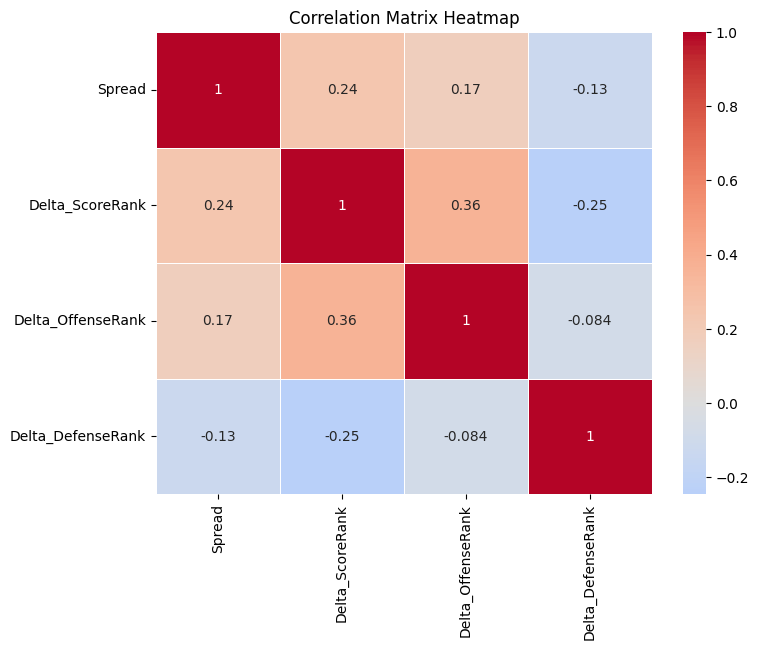

In [40]:
df = merged_played[['Spread',
                    'Delta_ScoreRank', 'Delta_OffenseRank','Delta_DefenseRank']]


# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

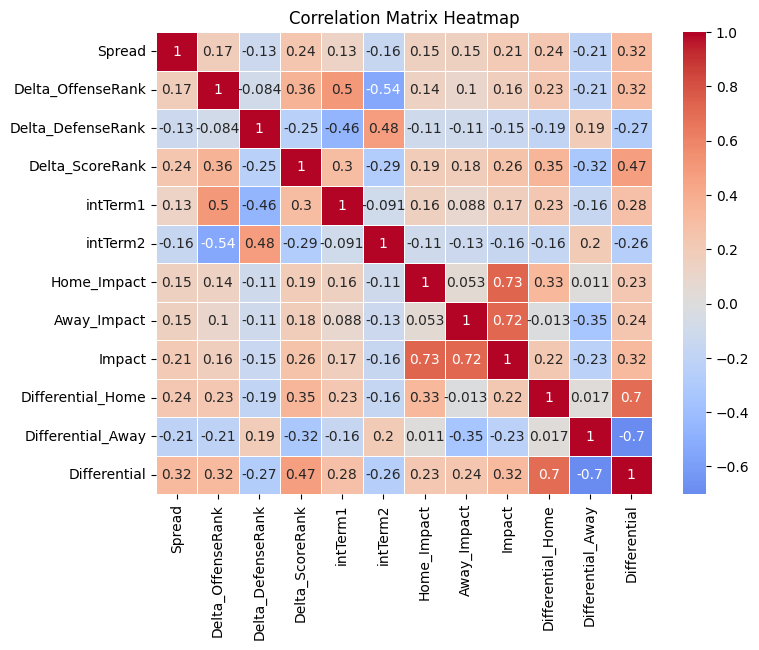

In [41]:
df = merged_played[['Spread',
                    'Delta_OffenseRank','Delta_DefenseRank', 'Delta_ScoreRank', 
                    'intTerm1', 'intTerm2',
                    'Home_Impact', 'Away_Impact', 'Impact',
                    'Differential_Home', 'Differential_Away','Differential'
                    ]]


# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()